In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline

In [2]:
def dist_coeffs(img_pattern, verbose=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    imgsize = None

    # Make a list of calibration images
    images = glob.glob(img_pattern) #'../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for img_idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        if imgsize == None:
            imgsize = gray.shape[::-1]
        elif imgsize != gray.shape[::-1]:
          print("Image {} has wrong size {}".format(fname, gray.shape[::-1]))  

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if verbose:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
            #plt.subplots(121)
            axes[0].imshow(img)#fig.imshow(img)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            if verbose:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                #plt.subplot(122)
                axes[1].imshow(img) #plt.imshow(img)
                #axes[int(img_idx/2), img_idx % 2].imshow(img)
                #cv2.waitKey(500)

    if verbose: plt.show()
    
    return cv2.calibrateCamera(objpoints, imgpoints, imgsize, None, None)
 

In [3]:
undist_err, mtx, dst_coefs, r_vecs, t_vecs = dist_coeffs('./camera_cal/calibration*.jpg')

Image ./camera_cal/calibration15.jpg has wrong size (1281, 721)
Image ./camera_cal/calibration7.jpg has wrong size (1281, 721)


In [4]:
def undistort(img):
    return cv2.undistort(img, mtx, dst_coefs)

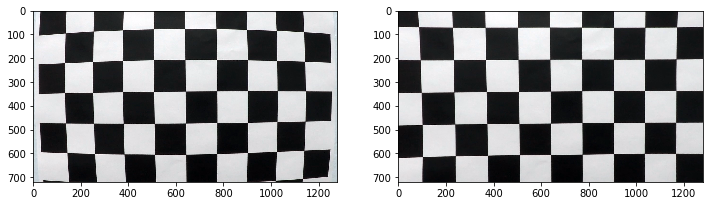

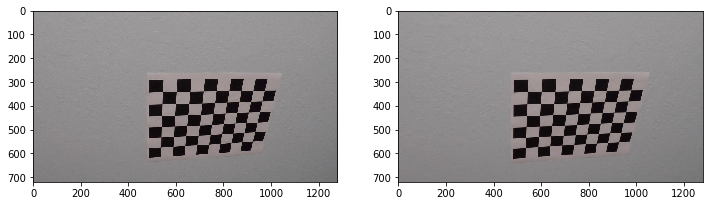

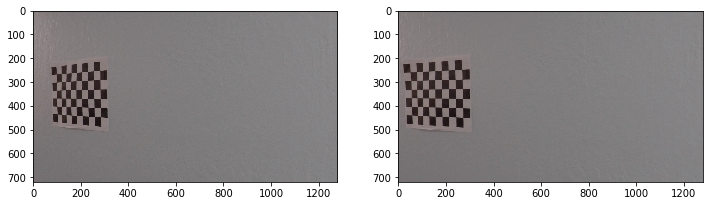

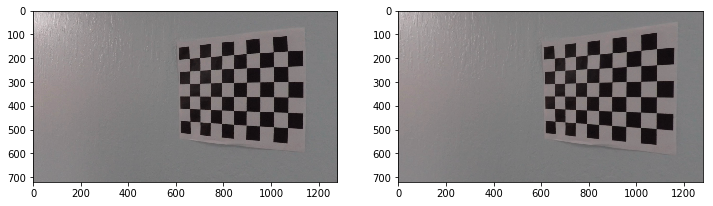

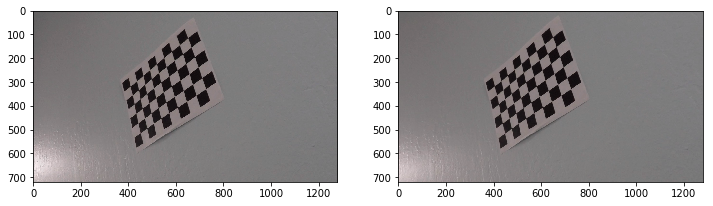

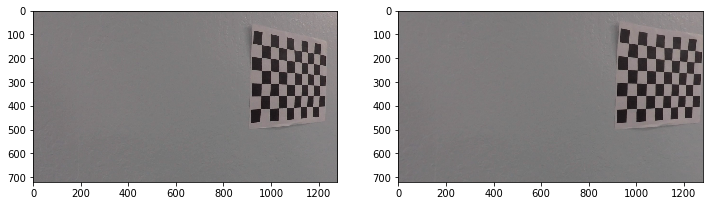

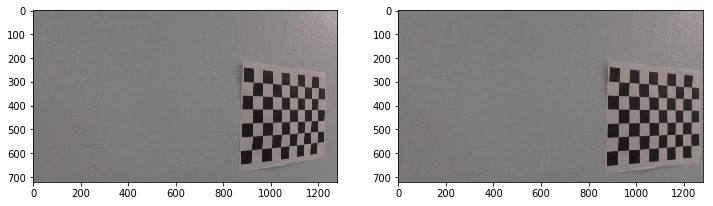

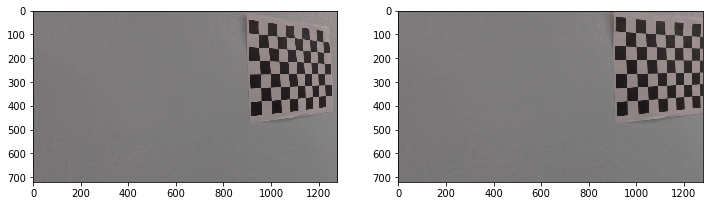

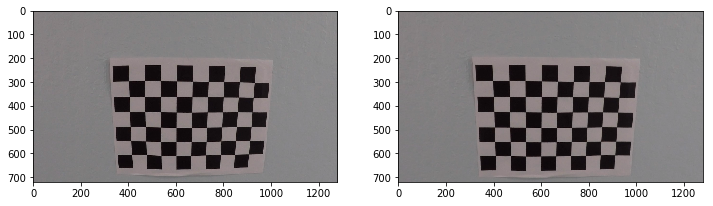

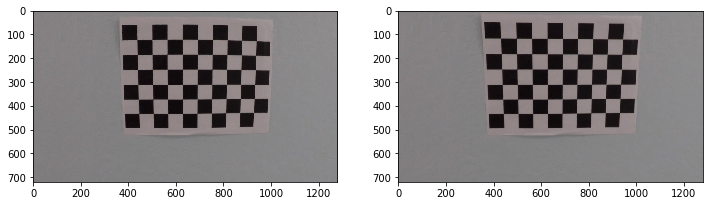

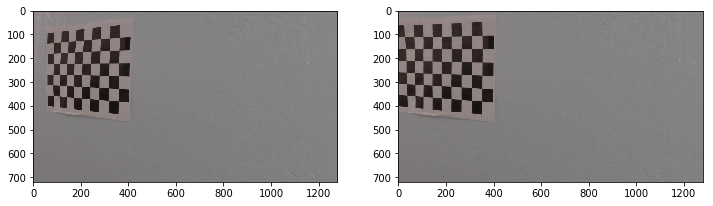

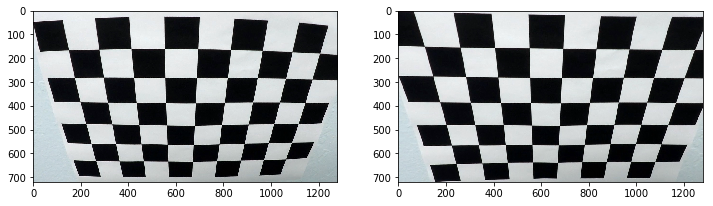

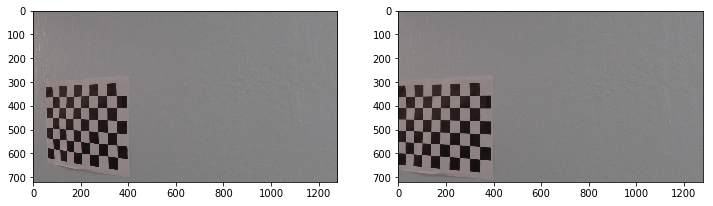

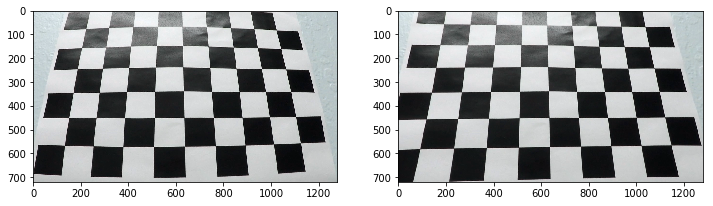

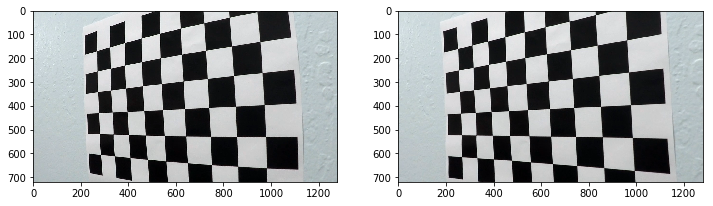

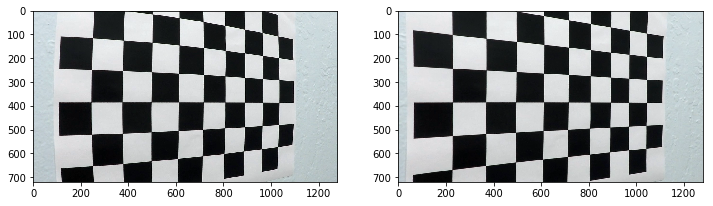

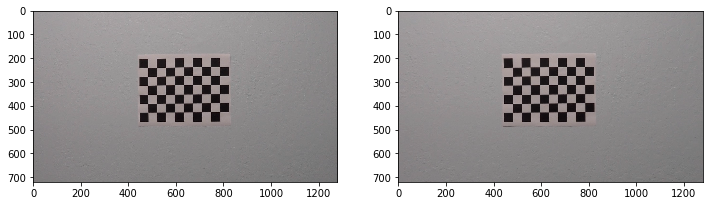

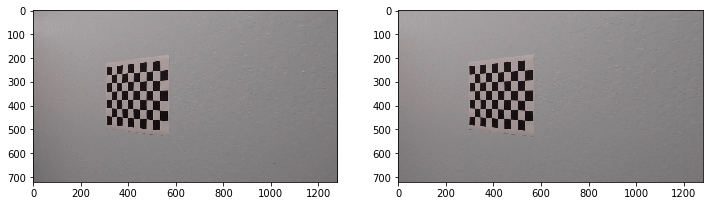

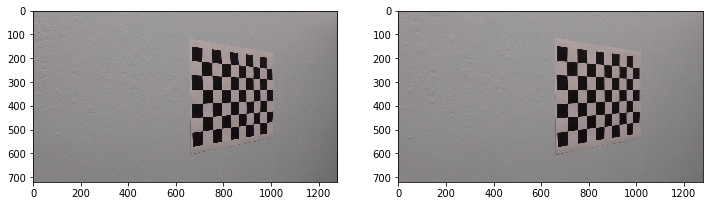

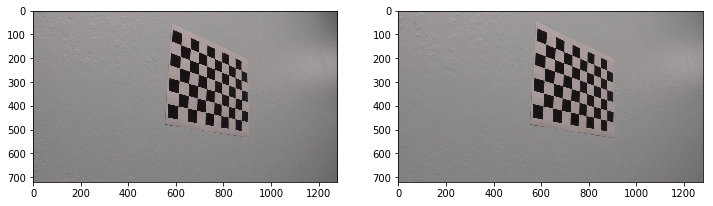

In [5]:
images = glob.glob('./camera_cal/calibration*.jpg')
for img_idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img) #cv2.undistort(img, mtx, dst_coefs)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
    axes[0].imshow(img)
    axes[1].imshow(dst)
plt.show()


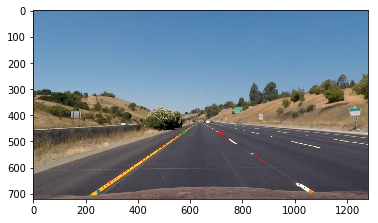

In [6]:
%matplotlib inline
img = mpimg.imread("test_images/straight_lines1.jpg")
img = undistort(img)
und_imgpoints = [[248, 690], [1058, 690], [573, 466], [711, 466]]
cv2.line(img, tuple(und_imgpoints[0]), tuple(und_imgpoints[2]), [255, 0, 0])
cv2.line(img, tuple(und_imgpoints[1]), tuple(und_imgpoints[3]), [255, 0, 0])
plt.imshow(img)
for p in und_imgpoints:
    plt.plot(p[0], p[1], '.')
und_imgpoints = np.float32(und_imgpoints)
plt.show()

In [7]:
unw_imgpoints = np.float32([[411, img.shape[0]-10], [884, img.shape[0]-10], [411, 10], [884, 10]])

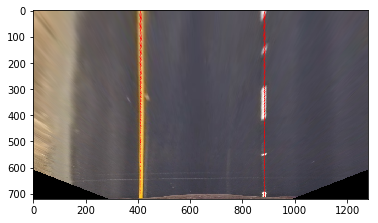

In [8]:
%matplotlib inline
warp_M = cv2.getPerspectiveTransform(und_imgpoints, unw_imgpoints)
warped = cv2.warpPerspective(img, warp_M, img.shape[-2::-1], flags=cv2.INTER_LINEAR)
plt.imshow(warped)
unwarp_M = cv2.getPerspectiveTransform(unw_imgpoints, und_imgpoints)

In [9]:
def warp_image(img, matrix):
    shape = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, matrix, shape, flags=cv2.INTER_LINEAR)

In [10]:

def get_sobel(img, orient, sobel_kernel):
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    x = orient == 'x'
    y = orient == 'y'
    return cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)

def threshold_img(img, threshold):
    result = np.zeros_like(img)
    result[(img >= threshold[0]) & (img <= threshold[1])] = 1
    return result


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    sobel = get_sobel(img, orient, sobel_kernel) 
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8(sobel * 255 / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    return threshold_img(sobel, thresh)

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 2) Take the gradient in x and y separately
    x_grad = get_sobel(image, 'x', sobel_kernel)
    y_grad = get_sobel(image, 'y', sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(np.square(x_grad) + np.square(y_grad))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    magnitude = np.uint8(magnitude * 255 / np.max(magnitude))
    return threshold_img(magnitude, mag_thresh)

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    x_grad = get_sobel(image, 'x', sobel_kernel)
    y_grad = get_sobel(image, 'y', sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(x_grad)
    abs_y = np.absolute(y_grad)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad = np.arctan2(abs_y, abs_x)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad)
    # 6) Return this mask as your binary_output image
    dir_binary[(grad > thresh[0]) & (grad < thresh[1])] = 1

    return dir_binary

def hls_select(image, threshold=None, channel=2):
    transformed = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,channel]
    if threshold == None:
        result = transformed
    else:
        result = np.zeros_like(transformed)
        result[(transformed > threshold[0]) & (transformed <= threshold[1])] = 1
    return result


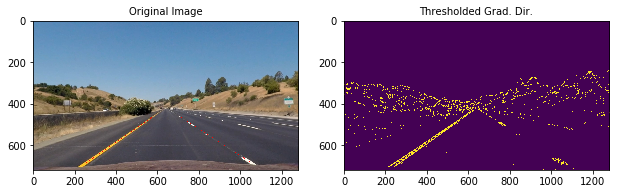

In [49]:
def gradient_combo(image, xthresh=(30,150), ythresh=(30,150), magthresh=(30,150)):
    ksize = 7 # Choose a larger odd number to smooth gradient measurements

    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=xthresh)
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=ythresh)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=magthresh)
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(.9, 1.2))

    #Try different combinations and see what you get.

    #For example, here is a selection for pixels where both the x and y gradients 
    #meet the threshold criteria, or the gradient magnitude and direction are both 
    #within their threshold values.

    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(gradient_combo(img))
ax2.set_title('Thresholded Grad. Dir.', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

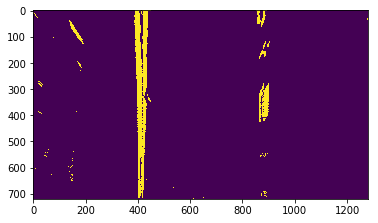

In [50]:
combo_warped = cv2.warpPerspective(gradient_combo(img), warp_M, img.shape[-2::-1], flags=cv2.INTER_LINEAR)
plt.imshow(combo_warped)

In [51]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

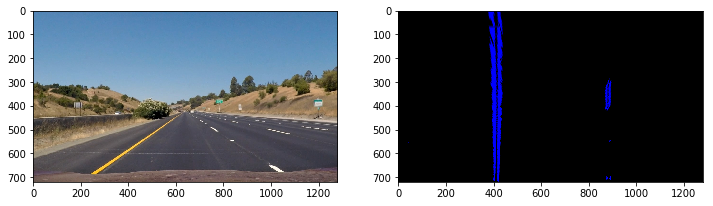

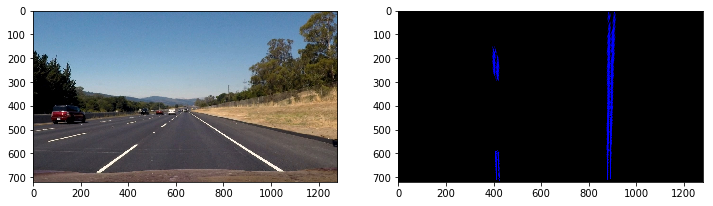

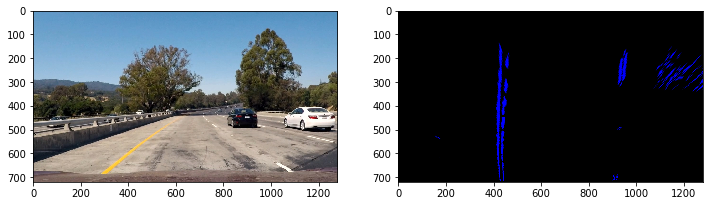

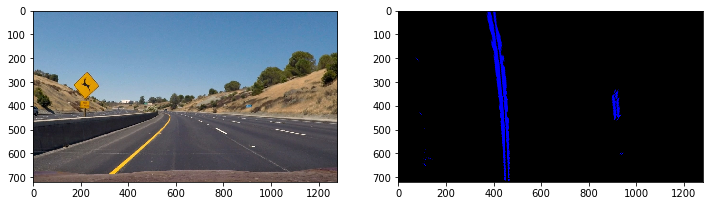

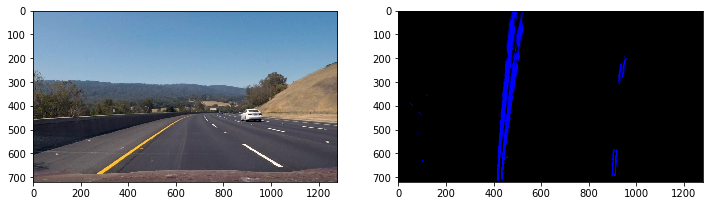

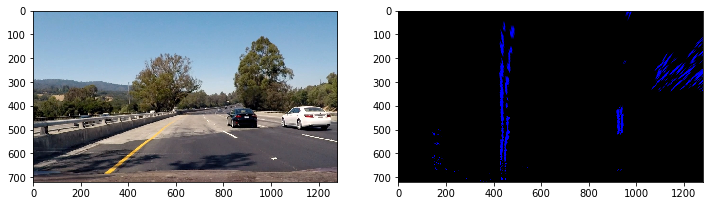

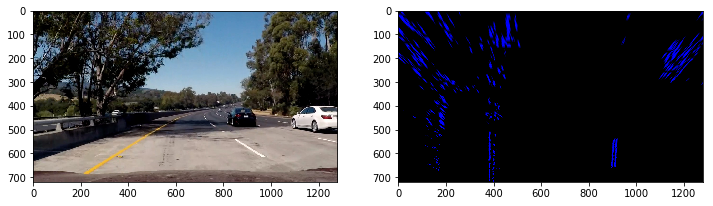

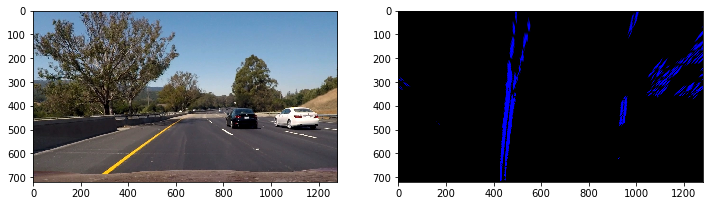

In [65]:
def process_image(image):
    result = undistort(image)
#    hls = hls_select(result, (80, 150), 2) * 255
    hls = hls_select(result)
#    rgb_grad = gradient_combo(result) * 255#, threshold=(80, 150))
    hls_grad = gradient_combo(hls, xthresh=(50, 250), ythresh=(50, 250), magthresh=(60, 200)) * 255
#    hls = hls_select(result, threshold=(50, 150)) * 255
    filler = np.zeros_like(hls)
#    hls = hls_select(result, threshold=(100, 150)) * 255
    result = np.dstack((filler, filler, hls_grad))
    result = warp_image(result, warp_M)
    return result
for tst_fname in glob.glob("test_images/*.jpg"):
    tst_image = plt.imread(tst_fname)
#    plt.imshow(process_image(tst_image))
    fig, (orig, processed) = plt.subplots(ncols=2, figsize=(12, 8))
    orig.imshow(tst_image)
    processed.imshow(process_image(tst_image))
plt.show()


In [ ]:
if not os.path.exists("test_videos_output"):
    os.mkdir('test_videos_output')
test_output = 'test_videos_output/test.mp4'
clip1 = VideoFileClip("project_video.mp4")
for i in range(20, 30, 2):
    frame1 = process_image(clip1.get_frame(i))
    plt.imshow(frame1)
    plt.show()

In [ ]:
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))